# Chpater 7 : Generate Sentence using RNN

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from common.rnnlm import Rnnlm
from common.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids = None, sample_size=100):
        word_ids = [start_id]
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

In [2]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words= ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you heard mr. holmes described on the reagan administration without sensitive is something right when i get things corporate .
 weiss .
 he is showing good .
 mr. roman met into m. dies most especially a man .
 mr. honecker the former first executive vice president order reportedly would try to broaden the mobile steelworkers collapse of the former president and chief of art .
 he sees it often if he would make part bush he said this sense to obtain legal problems at the telecommunications of union banking .
 american express 's dingell statement has heard in heart the


Better RNNLM 사용한 generate

In [3]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [4]:
import sys
sys.path.append('..')
from common.np import *
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('./BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids, sample_size=50)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)

# model.reset_state()

# start_words = 'the meaning of life is'
# start_ids = [word_to_id[w] for w in start_words.split(' ')]

# for x in start_ids[:-1]:
#     x = np.array(x).reshape(1, 1)
#     model.predict(x)

# word_ids = model.generate(start_ids[-1], skip_ids)
# word_ids = start_ids[:-1] + word_ids
# txt = ' '.join([id_to_word[i] for i in word_ids])
# txt = txt.replace(' <eos>', '.\n')
# print('-' * 50)
# print(txt)

you are glad to appear.
 i am not uncommon to bring a similar way.
 yet even forum a voice for every principal generation will not be affected.
 the family of those who come from real-estate companies can take four other steps to predict the cost of the


In [5]:
txt = '''you shifted many people.
 these advantages are not entirely on boys and someone believes is that it 's unfortunate to resist a new cement name but they describe us now favors personal reasons.
 apparently the best firms are attractive to medium-sized policies of cigna and pork prices.'''

len(txt.split())

# <EOS>를 replace 하여 47개

47

In [6]:
import sys
sys.path.append('..')
from dataset import sequence

(X_train, t_train), (X_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(X_train.shape, t_train.shape)
print(''.join([id_to_char[c] for c in X_train[0]]))


(45000, 7) (45000, 5)
71+118 


In [12]:
from common.time_layers import *
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4* H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [13]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4* H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, h):
            self.lstm.set_state(h)

            out = self.embed.forward(xs)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            return score
        
    def backward(self, dscore):
            dout = self.affine.backward(dscore)
            dout = self.lstm.backward(dout)
            dout = self.embed.backward(dout)
            dh = self.lstm.dh
            return dh
        
    def generate(self, h, start_id, sample_size):
            sampled = []
            sample_id = start_id
            self.lstm.set_state(h)

            for _ in range(sample_size):
                x = np.array(sample_id).reshape((1, 1))
                out = self.embed.forward(x)
                out = self.lstm.forward(out)
                score = self.affine.forward(out)

                sample_id = np.argmax(score)
                sampled.append(sample_id)
            return sampled

In [14]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.util import *
from common.base_model import *

class Seq2Seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D , H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [15]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from peeky_seq2seq import PeekySeq2seq

(X_train, t_train), (X_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

vocab_size = len(char_to_id)
wordvec_size= 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2Seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(X_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(X_test)):
        question, correct = X_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, char_to_id)
    acc = float(correct_num) / len(X_test)
    acc_list.append(acc)
    print("validation accuracy :", acc * 100)

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 8[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

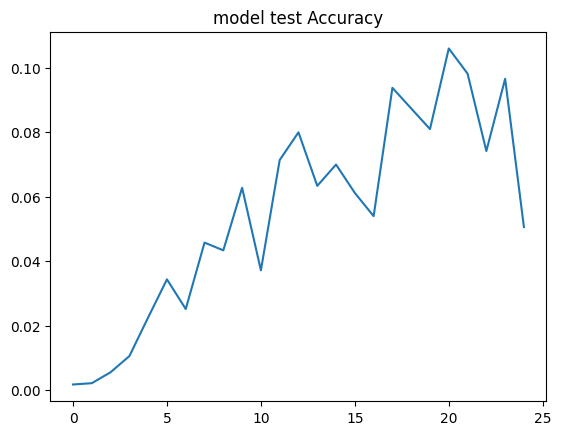

In [17]:
import matplotlib.pyplot as plt

plt.title("model test Accuracy")
plt.plot(acc_list)
